In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io

2023-10-23 22:44:24.450345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!ls

README.md                  test
__pycache__                train
rooftop-segmentation.ipynb


Training images:  ['417.png', '317.png', '303.png', '328.png', '300.png', '314.png', '274.png', '315.png', '301.png', '270.png', '272.png', '121.png', '337.png', '241.png', '532.png', '320.png', '308.png', '324.png', '278.png', '287.png', '284.png', '381.png', '343.png', '379.png', '345.png']
Inspect 1 train image
Max value:  1.0
Image shape:  (256, 256, 4)


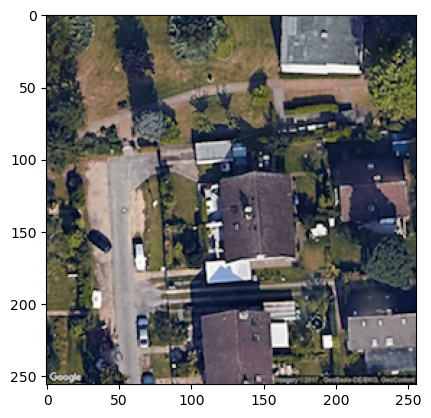

In [3]:
print('Training images: ', os.listdir("train/images"))
print('Inspect 1 train image')
img = plt.imread(os.path.join("train/images/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
imgplot = plt.imshow(img)

Inspect 1 train mask
Max value:  1.0
Image shape:  (256, 256)
Pixels in (256,256) img with value 1 : 9200
Pixels in (256,256) img with value 0 : 52917
Pixels in (256,256) img with value between 0 and 1 : 3419


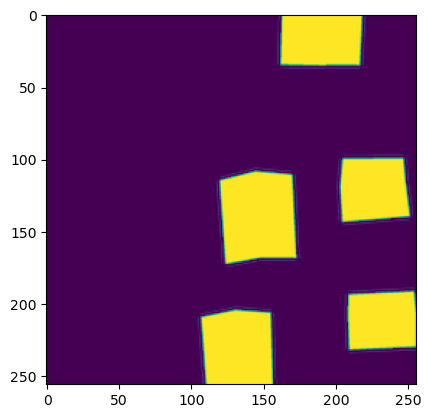

In [4]:
print('Inspect 1 train mask')
img = plt.imread(os.path.join("train/labels/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
print('Pixels in (256,256) img with value 1 :',np.sum(img==1.0))
print('Pixels in (256,256) img with value 0 :',np.sum(img==0.0))
print('Pixels in (256,256) img with value between 0 and 1 :',np.sum(img>0.0)-np.sum(img==1.0))
imgplot = plt.imshow(img)

As we see, the mask has values 0, 1 and values between 0 and 1. These last values are in pixels that contain the border of the shape of the roof. 

In [5]:
# define the types of augmentations
aug_dict = dict(rotation_range=0.2,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                fill_mode='nearest')

# define the right folders and 
batch_size=2 
train_path='train'
image_folder='images'
mask_folder='labels'
image_color_mode='rgba'
mask_color_mode='grayscale'
target_size=(256,256)
seed=1 


# define the data generators
image_datagen = ImageDataGenerator(**aug_dict)
mask_datagen = ImageDataGenerator(**aug_dict)


image_generator = image_datagen.flow_from_directory(
    train_path,
    classes = [image_folder],
    class_mode = None,
    color_mode = image_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes = [mask_folder],
    class_mode = None,
    color_mode = mask_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
train_generator = zip(image_generator, mask_generator)


# With our Generator function we can keep on calling augmented images.
# This will be used when training the model.
# we transform the pixels in the mask on the border of the roofs in the mask
# to either 0 or 1. And if needed (just to be sure) resize the images.
def Generator(train_generator):
  for (img,mask) in train_generator:
      if(np.max(img) > 1):
        img = img / 255.
        mask = mask /255.
      mask[mask > 0.5] = 1
      mask[mask <= 0.5] = 0
      yield (img,mask)
      
myGene = Generator(train_generator)

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


/var/folders/f8/pr3njbwj3vl3_thlf_2n0njr0000gp/T/ipykernel_10137/507034984.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


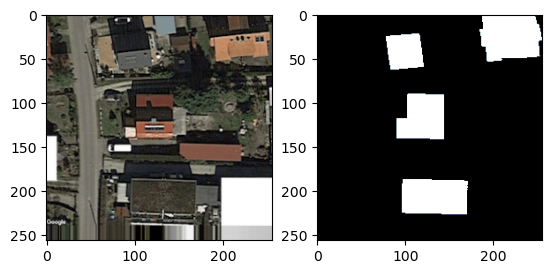

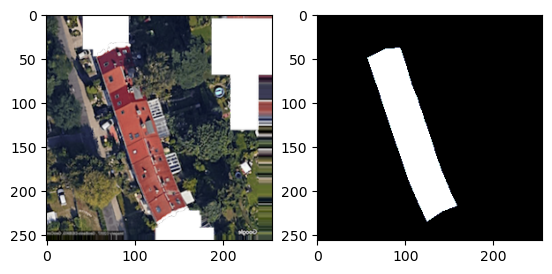

In [6]:
# check if images images are zipped
for b in range(1):
    example = next(myGene)
    for i in range(batch_size):
      img=example[0][i]
      mask=example[1][i]
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img.squeeze(), cmap=plt.get_cmap('bone'))
      ax[1].imshow(mask.squeeze(), cmap=plt.get_cmap('bone'))
      fig.show()

In [7]:
mask=example[1][0]
print('Verify only 1 and 0 in mask:\n')
print('pix in mask with value 1 :',np.sum(mask==1.0))
print('pix in mask with value 0 :',np.sum(mask==0.0))
print('pix in mask with value no 0 or 1 :',np.sum(mask>0.0)-np.sum(mask==1.0))

Verify only 1 and 0 in mask:

pix in mask with value 1 : 10003
pix in mask with value 0 : 55533
pix in mask with value no 0 or 1 : 0


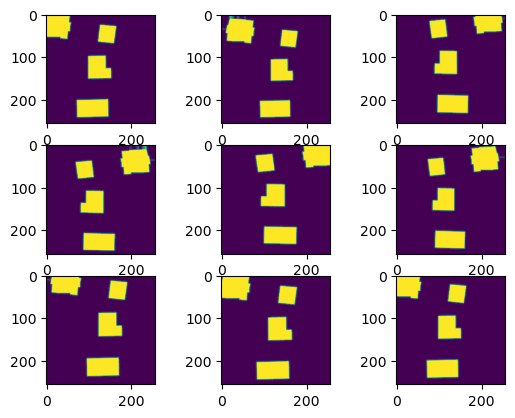

In [8]:
# see some augmentations of one mask
i=0
for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = mask_generator[0][0]
	plt.imshow(batch.squeeze())
plt.show()

In [9]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model




In [11]:
epochs=5
steps_per_epoch=100
model = unet(input_size = (256,256,4))
model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs)


Epoch 1/5


/var/folders/f8/pr3njbwj3vl3_thlf_2n0njr0000gp/T/ipykernel_10137/2086493872.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs)


100/100 [==============================] - 289s 3s/step - loss: 0.4294 - accuracy: 0.8561
Epoch 2/5
100/100 [==============================] - 305s 3s/step - loss: 0.4105 - accuracy: 0.8565
Epoch 3/5
100/100 [==============================] - 323s 3s/step - loss: 0.3988 - accuracy: 0.8567
Epoch 4/5
100/100 [==============================] - 346s 3s/step - loss: 0.3999 - accuracy: 0.8565
Epoch 5/5
100/100 [==============================] - 337s 3s/step - loss: 0.3988 - accuracy: 0.8548


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_path='test'
image_folder='images'

test_generator = test_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = 1)
 
filenames = [x[-7:] for x in test_generator.filenames]
test_samples = len(filenames)

results = model.predict_generator(test_generator,steps = test_samples, verbose=1)

Found 5 images belonging to 1 classes.


/var/folders/f8/pr3njbwj3vl3_thlf_2n0njr0000gp/T/ipykernel_10137/1549965444.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_generator,steps = test_samples, verbose=1)


5/5 [==============================] - 1s 254ms/step


In [22]:
def saveResult(save_path,results,filenames):
    for i,item in enumerate(results):
        img = item[:,:,0]
        img_name = filenames[i]
        io.imsave(os.path.join(save_path, img_name),img)
        
saveResult("test/labels/",(results*255).astype(np.uint8), filenames)



Epoch 1/5


/var/folders/f8/pr3njbwj3vl3_thlf_2n0njr0000gp/T/ipykernel_10137/2003748402.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(myGene, steps_per_epoch=steps_per_epoch, epochs=epochs)


100/100 [==============================] - 318s 3s/step - loss: 0.3971 - accuracy: 0.8551
Epoch 2/5
100/100 [==============================] - 349s 3s/step - loss: 0.3913 - accuracy: 0.8571
Epoch 3/5
100/100 [==============================] - 340s 3s/step - loss: 0.3925 - accuracy: 0.8553
Epoch 4/5
100/100 [==============================] - 351s 4s/step - loss: 0.3896 - accuracy: 0.8557
Epoch 5/5
100/100 [==============================] - 349s 3s/step - loss: 0.3876 - accuracy: 0.8564


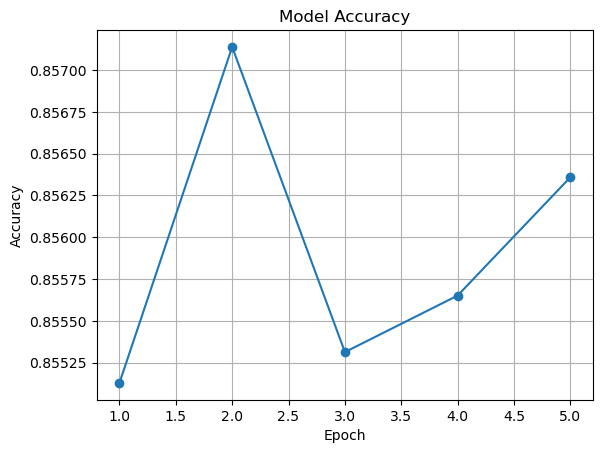

In [21]:
import matplotlib.pyplot as plt

# ... your previous code ...

# Fit the model and store the training history
history = model.fit_generator(myGene, steps_per_epoch=steps_per_epoch, epochs=epochs)

# Extract accuracy values from the history
accuracy = history.history['accuracy']

# Plot the accuracy over epochs
plt.plot(range(1, epochs + 1), accuracy, marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
